In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

import utils

mnist_path = 'data/mnist-zoomed-to-bounds.npy'
model_path = 'data/model'

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
# Use cached augmented data if it exists
if os.path.isfile(mnist_path) is False:
    print("Normalizing mnist data set")
    mnist = tf.keras.datasets.mnist

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train / 255.0
    x_test  = x_test  / 255.0
    
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test  = x_test.reshape(x_test.shape[0], 28, 28, 1)

    x_train = np.array([utils.zoom_to_bounds(img_array) for img_array in x_train])
    x_test  = np.array([utils.zoom_to_bounds(img_array) for img_array in x_test])

    to_save =  np.array( ([x_train, y_train], [x_test, y_test]) )
    np.save(mnist_path, to_save)
else:
    print("Using cached mnist data set")
    (x_train, y_train), (x_test, y_test) = np.load(mnist_path, allow_pickle=True)

Using cached mnist data set


In [4]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [5]:
predictions = model(x_train[:1]).numpy()
predictions

array([[ 0.01932831, -0.9723643 , -0.31897578, -0.02924559,  0.0501269 ,
         0.87297696, -0.8352095 , -0.0786638 ,  0.30412713, -0.7727542 ]],
      dtype=float32)

In [6]:
tf.nn.softmax(predictions).numpy()

array([[0.10492603, 0.03892214, 0.07481001, 0.09995119, 0.1082079 ,
        0.24638723, 0.04464392, 0.09513184, 0.1394986 , 0.04752107]],
      dtype=float32)

In [7]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [8]:
loss_fn(y_train[:1], predictions).numpy()

1.4008508

In [9]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=12)
model.evaluate(x_test,  y_test, verbose=2)

# Not overwriting if already exists!
if os.path.isfile(model_path) is False:
    model.save(model_path)

Epoch 1/12
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2876 - accuracy: 0.9162
Epoch 2/12
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1502 - accuracy: 0.9546
Epoch 3/12
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1216 - accuracy: 0.9633
Epoch 4/12
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1060 - accuracy: 0.9665
Epoch 5/12
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0941 - accuracy: 0.9704
Epoch 6/12
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0857 - accuracy: 0.9735
Epoch 7/12
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0806 - accuracy: 0.9744
Epoch 8/12
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0761 - accuracy: 0.9761
Epoch 9/12
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0680 - accuracy: 0.9786
Epoch 10/12
1875/1875 [==============================] - 4s 2ms/step - loss: 0.064

In [10]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [11]:
pngs = sorted(glob("data/pngs/*.png"))
def load_image(path):
    image     = tf.keras.preprocessing.image.load_img(path, color_mode="grayscale", target_size=(28,28), interpolation='nearest')
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    return input_arr / 255

actual_data = [load_image(png) for png in pngs]
actual_data = np.array(actual_data)
actual_data.shape

(37, 28, 28, 1)

C:\Users\verst\AppData\Local\Temp/ipykernel_4300/2132475441.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))


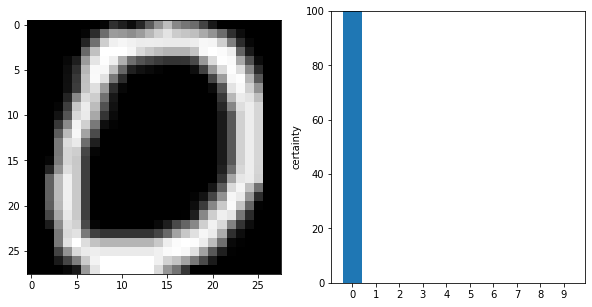

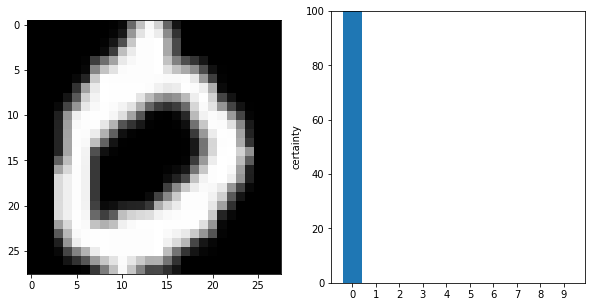

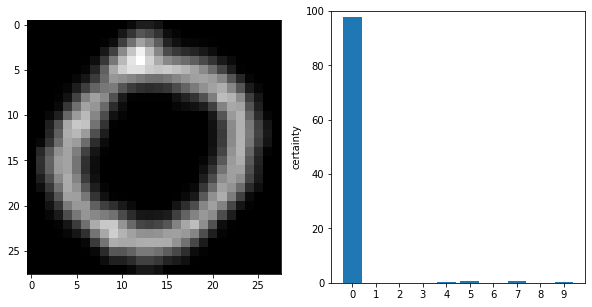

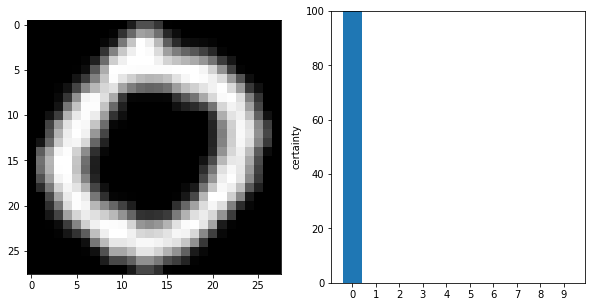

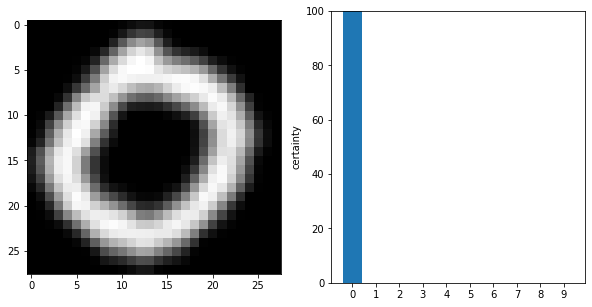

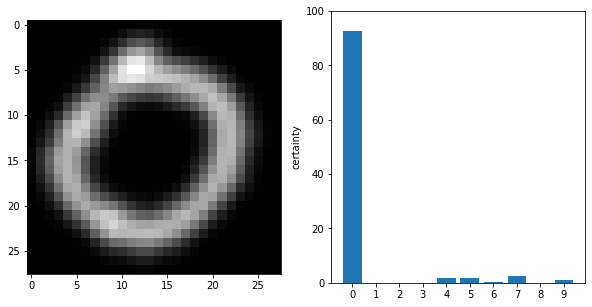

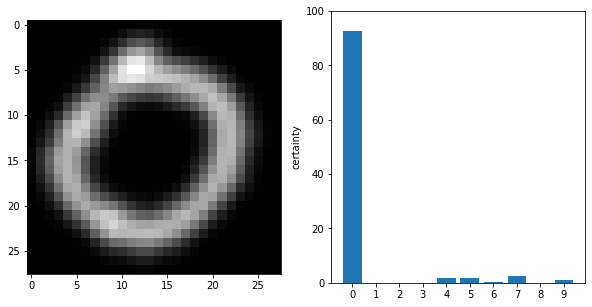

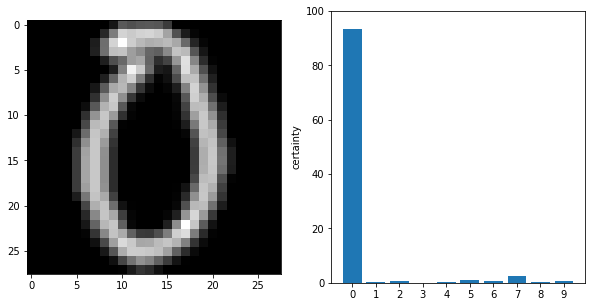

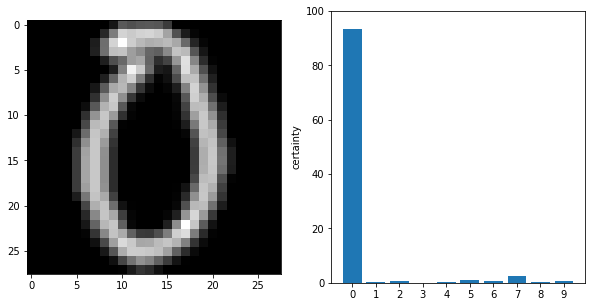

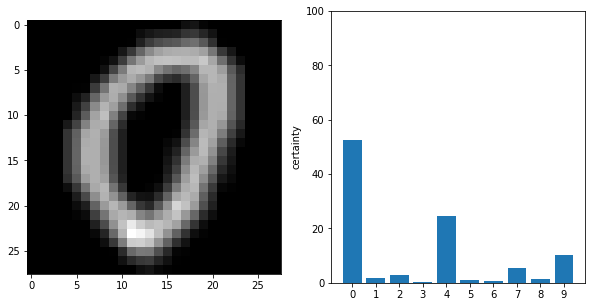

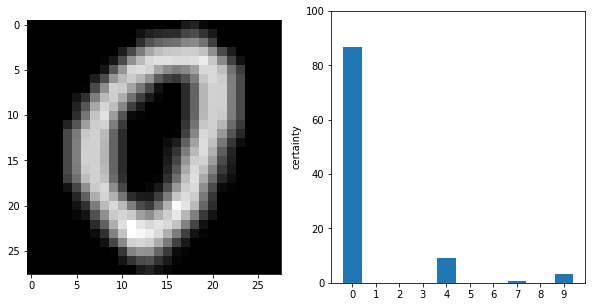

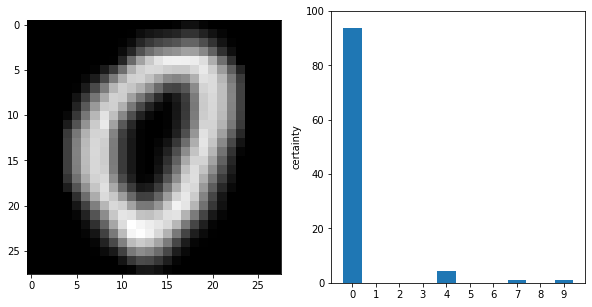

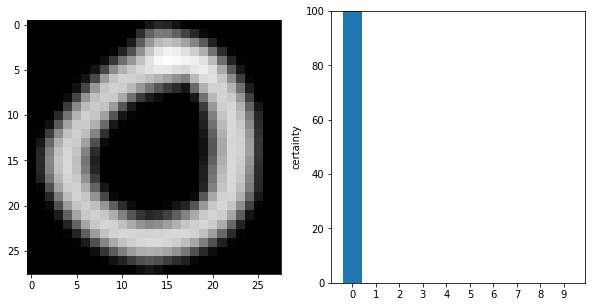

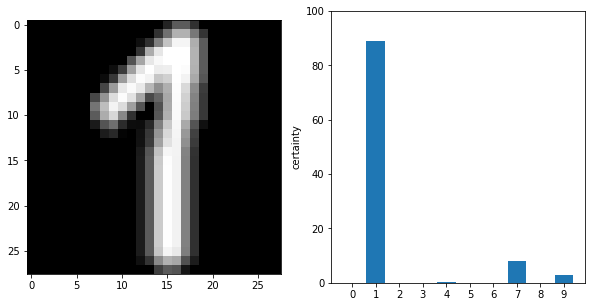

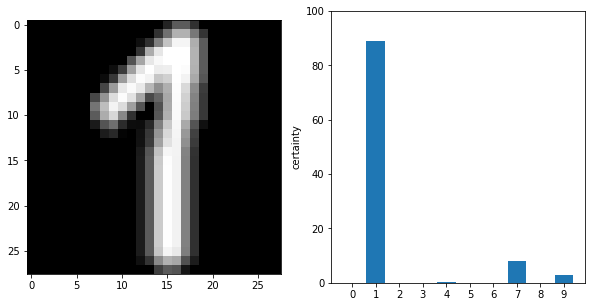

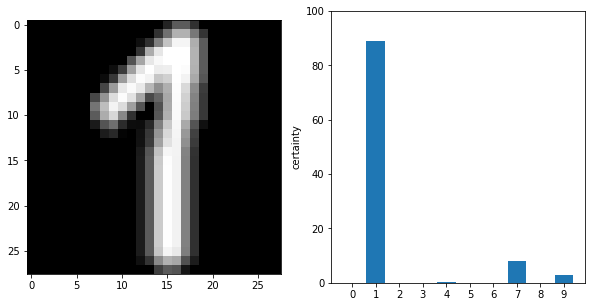

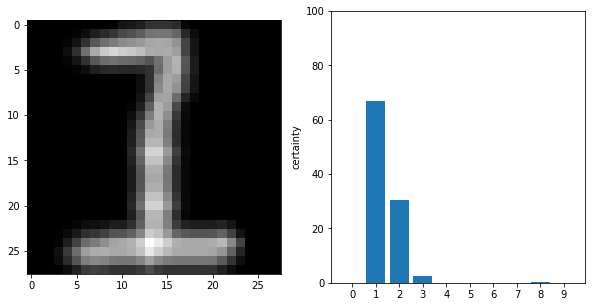

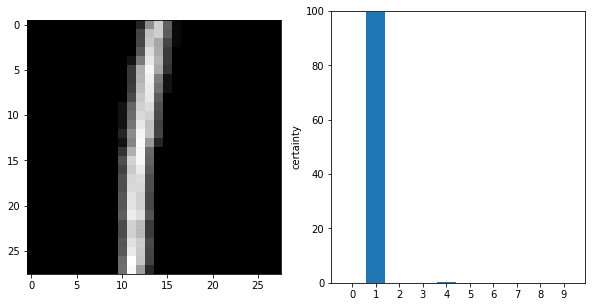

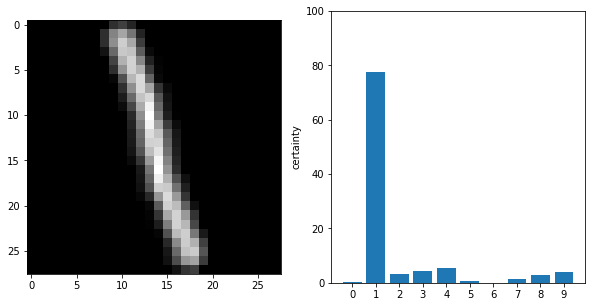

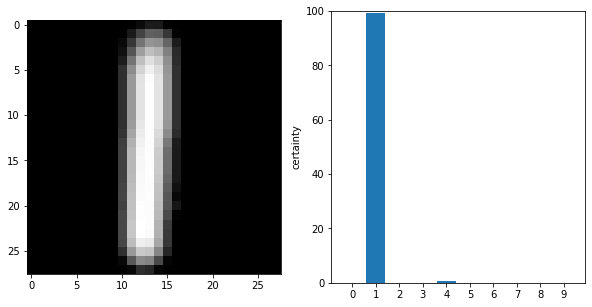

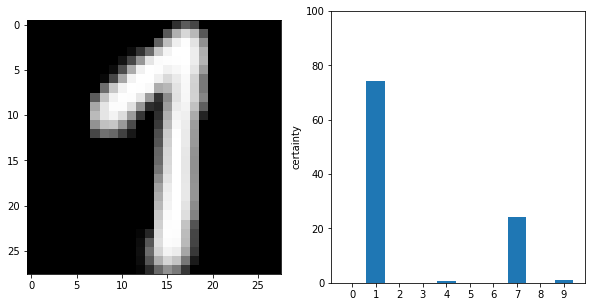

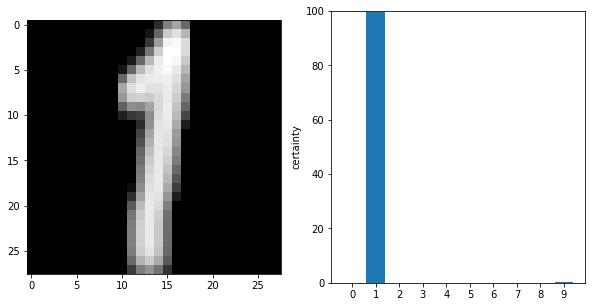

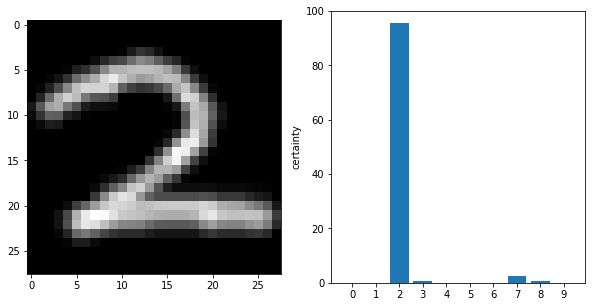

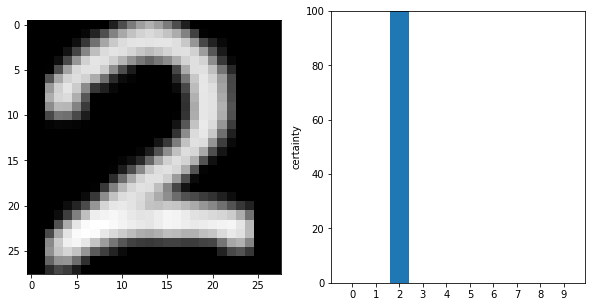

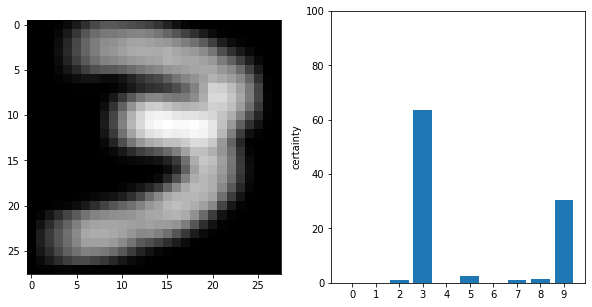

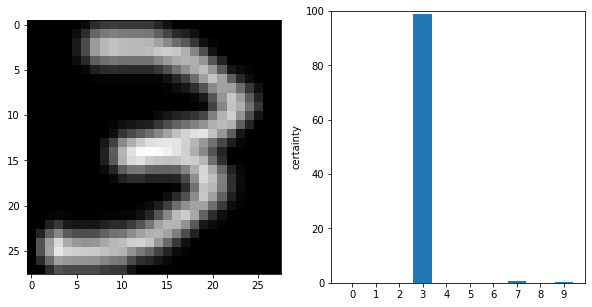

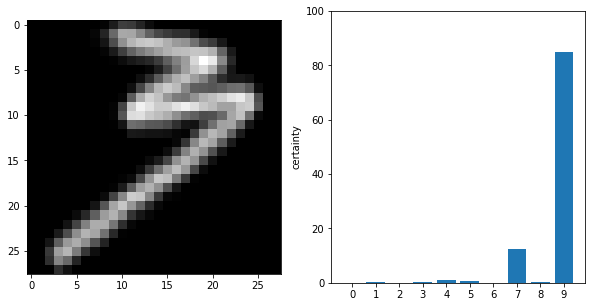

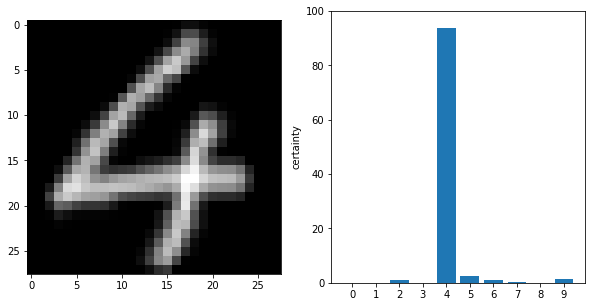

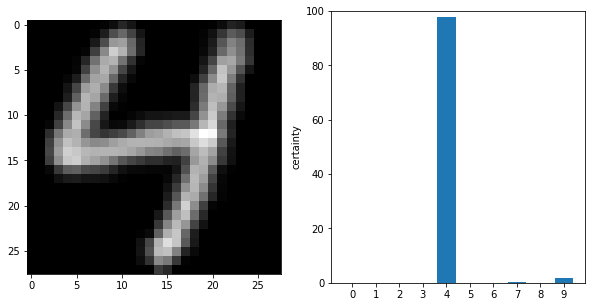

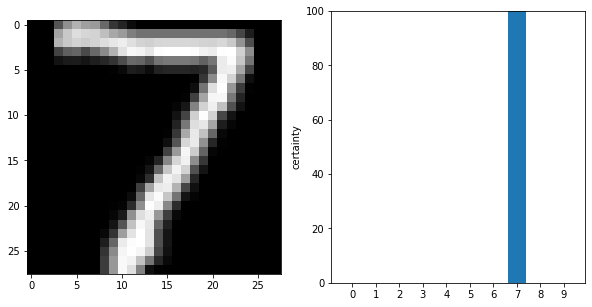

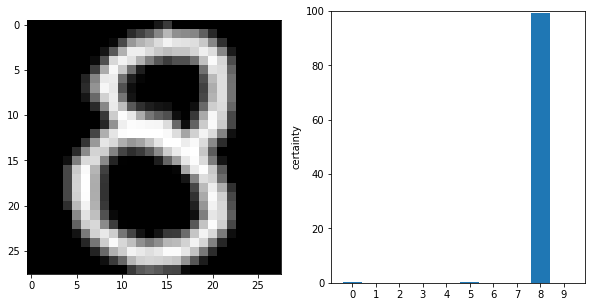

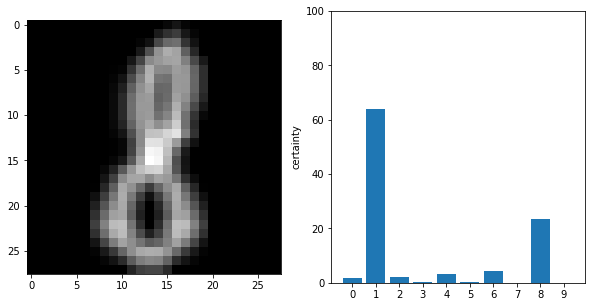

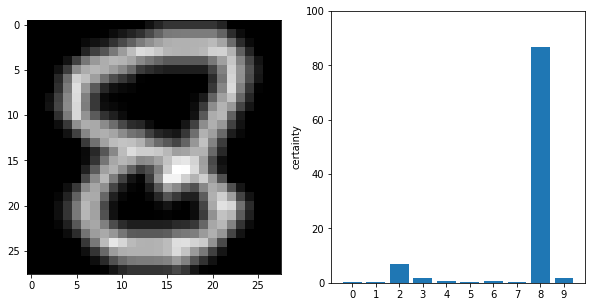

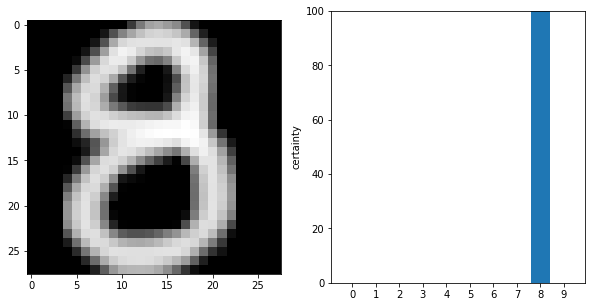

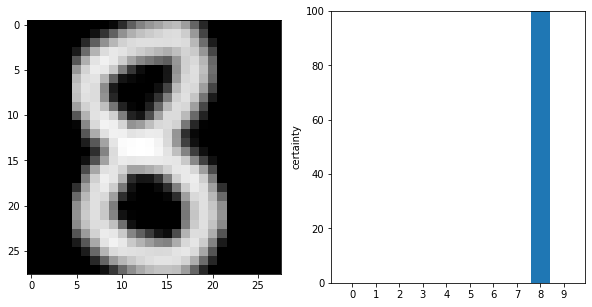

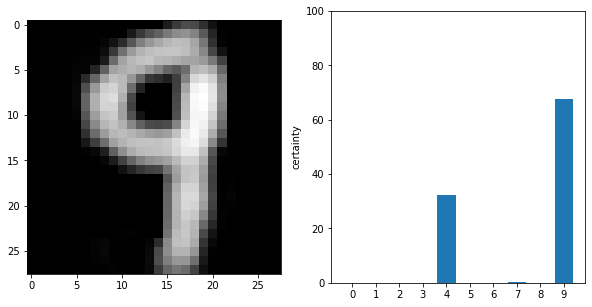

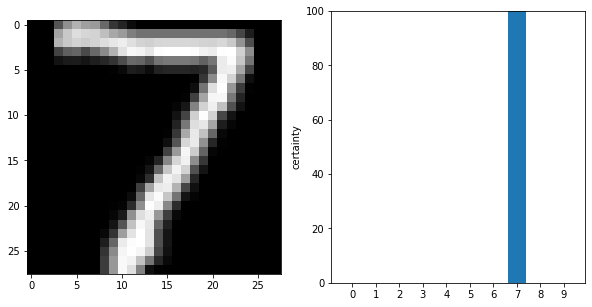

In [50]:
data = np.array([utils.zoom_to_bounds(img_array) for img_array in actual_data[:100]])
predictions = probability_model(data) * 100
for i, d in enumerate(data):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.imshow(d, cmap="gray")
    ax2.bar(x=range(0, 10), height=predictions[i], tick_label=range(0, 10))
    ax2.set(ylabel="certainty", ylim=(0, 100))
